In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
from scipy.stats import shapiro
from scipy.stats import probplot
from scipy.stats import mannwhitneyu
from scipy.stats import chi2_contingency
import seaborn as sns

In [3]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (roc_auc_score, roc_curve, auc, confusion_matrix, \
                             accuracy_score, classification_report, plot_confusion_matrix, \
                             plot_precision_recall_curve, precision_recall_curve, recall_score,
                             plot_roc_curve)
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from scipy.sparse import hstack
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [4]:
import warnings
warnings.filterwarnings('ignore')

In [10]:
!pip install scikit-uplift catboost==0.22 -U
!pip install causalml

     |████████████████████████████████| 64.4MB 71kB/s 
     |████████████████████████████████| 245kB 10.5MB/s 
     |████████████████████████████████| 20.1MB 1.4MB/s 
     |████████████████████████████████| 327kB 44.3MB/s 
     |████████████████████████████████| 1.8MB 36.4MB/s 
     |████████████████████████████████| 634kB 49.2MB/s 
  Created wheel for causalml: filename=causalml-0.10.0-cp37-cp37m-linux_x86_64.whl size=493677 sha256=747e1b3442f8d5c6640f12ab998f7bce322ea12a49d68c730f727fcf6eda5a37
  Stored in directory: /root/.cache/pip/wheels/81/7f/44/c9d5ecf03f0d950f53302a5eab1c76bec07bcd5868753e22bf
  Created wheel for shap: filename=shap-0.37.0-cp37-cp37m-linux_x86_64.whl size=465045 sha256=4abb9990a0eaa2de4772e9c838fc389017ce819856a9a3f0af9e6f590ec7f7ca
  Stored in directory: /root/.cache/pip/wheels/df/ad/b0/aa7815ec68850d66551ef618095eccb962c8f6022f1d3dd989
Successfully built causalml shap
ERROR: tensorflow 2.4.1 has requirement numpy~=1.19.2, but you'll have numpy 1.18.5 which is

In [5]:
def evaluate_preds(model, X_train, X_test, y_train, y_test):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

In [6]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

In [18]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [19]:
TRAIN_DATASET_PATH = '/gdrive/MyDrive/ML/new_train.csv'

In [20]:
df = pd.read_csv(TRAIN_DATASET_PATH)
df.head()

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,treatment,target
0,10,-0.389003,1,0,0,0,0,1,0
1,6,0.339614,1,1,1,1,1,0,0
2,7,-0.239836,0,1,0,1,1,1,0
3,9,1.693278,1,0,1,1,1,1,0
4,2,-0.768068,1,0,2,0,1,1,0


In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64000 entries, 0 to 63999
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   recency        64000 non-null  int64  
 1   history        64000 non-null  float64
 2   used_discount  64000 non-null  int64  
 3   used_bogo      64000 non-null  int64  
 4   zip_code       64000 non-null  int64  
 5   is_referral    64000 non-null  int64  
 6   channel        64000 non-null  int64  
 7   treatment      64000 non-null  int64  
 8   target         64000 non-null  int64  
dtypes: float64(1), int64(8)
memory usage: 4.4 MB


In [22]:
TARGET_NAME = 'target'

In [23]:
NUM_FEATURE_NAMES = ['history']
CAT_FEATURE_NAMES = ['recency', 'channel', 'treatment']
BASE_FEATURE_NAMES = ['used_discount', 'used_bogo', 'zip_code', 'is_referral']
SELECTED_FEATURE_NAMES = NUM_FEATURE_NAMES + CAT_FEATURE_NAMES + BASE_FEATURE_NAMES

Model learning

In [24]:
X = df[SELECTED_FEATURE_NAMES]
y = df[TARGET_NAME]

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, random_state=21, stratify=y)

display(y_train.value_counts(normalize=True), y_test.value_counts(normalize=True))

0    0.853214
1    0.146786
Name: target, dtype: float64

0    0.853229
1    0.146771
Name: target, dtype: float64

In [26]:
NUM_FEATURE_NAMES = ['history']
CAT_FEATURE_NAMES = ['recency', 'channel']
BASE_FEATURE_NAMES = ['used_discount', 'used_bogo', 'zip_code', 'is_referral']
SELECTED_FEATURE_NAMES = NUM_FEATURE_NAMES + CAT_FEATURE_NAMES + BASE_FEATURE_NAMES

In [27]:
treat_train = X_train['treatment']

In [28]:
X_train = X_train[SELECTED_FEATURE_NAMES].copy()

In [29]:
treat_test = X_test['treatment']
X_test = X_test[SELECTED_FEATURE_NAMES].copy()

In [30]:
X_test

,history,recency,channel,used_discount,used_bogo,zip_code,is_referral
19993,-0.748978,4,1,1,0,0,1
58806,-0.827992,9,0,1,0,0,1
46174,0.049284,1,2,0,1,1,1
14985,-0.700414,7,1,0,1,0,1
4829,-0.401729,12,0,0,1,0,0
...,...,...,...,...,...,...,...
39507,-0.600904,3,0,1,0,0,0
54490,0.716298,9,1,1,0,0,0
5955,-0.761587,8,1,0,1,0,0
34655,-0.192053,5,1,1,0,0,0


In [31]:
models_results = {
    'approach': [],
    'uplift@10%': [],
    'uplift@20%': [],
    'uplift@30%': []
}


Одна модель с признаком коммуникации

In [36]:
# Инструкция по установке пакета: https://github.com/maks-sh/scikit-uplift
# Ссылка на документацию: https://scikit-uplift.readthedocs.io/en/latest/
from sklift.metrics import uplift_at_k
from sklift.viz import plot_uplift_preds
from sklift.models import SoloModel

# sklift поддерживает любые модели, 
# которые удовлетворяют соглашениями scikit-learn
# Для примера воспользуемся catboost
from catboost import CatBoostClassifier


sm = SoloModel(CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True))
sm = sm.fit(X_train, y_train, treat_train, estimator_fit_params={'cat_features': CAT_FEATURE_NAMES})

uplift_sm = sm.predict(X_test)

sm_score_10 = uplift_at_k(y_true=y_test, uplift=uplift_sm, treatment=treat_test, strategy='by_group', k=0.1)
sm_score_20 = uplift_at_k(y_true=y_test, uplift=uplift_sm, treatment=treat_test, strategy='by_group', k=0.2)
sm_score_30 = uplift_at_k(y_true=y_test, uplift=uplift_sm, treatment=treat_test, strategy='by_group', k=0.3)


models_results['approach'].append('SoloModel')
models_results['uplift@10%'].append(sm_score_10)
models_results['uplift@20%'].append(sm_score_20)
models_results['uplift@30%'].append(sm_score_30)

# Получим условные вероятности выполнения целевого действия при взаимодействии для каждого объекта
sm_trmnt_preds = sm.trmnt_preds_
# И условные вероятности выполнения целевого действия без взаимодействия для каждого объекта
sm_ctrl_preds = sm.ctrl_preds_

# Отрисуем распределения вероятностей и их разность (uplift)
#plot_uplift_preds(trmnt_preds=sm.trmnt_preds_, ctrl_preds=sm.ctrl_preds_)

In [ ]:
models_results

{'approach': ['SoloModel'],
 'uplift@10%': [0.09738141421266092],
 'uplift@20%': [0.0729662610944572],
 'uplift@30%': [0.07526107486431943]}

In [ ]:
from sklift.models import TwoModels


tm = TwoModels(
    estimator_trmnt=CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True), 
    estimator_ctrl=CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True), 
    method='vanilla'
)
tm = tm.fit(
    X_train, y_train, treat_train,
    estimator_trmnt_fit_params={'cat_features': CAT_FEATURE_NAMES}, 
    estimator_ctrl_fit_params={'cat_features': CAT_FEATURE_NAMES}
)

uplift_tm = tm.predict(X_test)

tm_score_10 = uplift_at_k(y_true=y_test, uplift=uplift_tm, treatment=treat_test, strategy='by_group', k=0.1)
tm_score_20 = uplift_at_k(y_true=y_test, uplift=uplift_tm, treatment=treat_test, strategy='by_group', k=0.2)
tm_score_30 = uplift_at_k(y_true=y_test, uplift=uplift_tm, treatment=treat_test, strategy='by_group', k=0.3)

models_results['approach'].append('TwoModels')
models_results['uplift@10%'].append(tm_score_10)
models_results['uplift@20%'].append(tm_score_20)
models_results['uplift@30%'].append(tm_score_30)

#plot_uplift_preds(trmnt_preds=tm.trmnt_preds_, ctrl_preds=tm.ctrl_preds_);

In [ ]:
from sklift.models import ClassTransformation


ct = ClassTransformation(CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True))
ct = ct.fit(X_train, y_train, treat_train, estimator_fit_params={'cat_features': CAT_FEATURE_NAMES})

uplift_ct = ct.predict(X_test)

ct_score_10 = uplift_at_k(y_true=y_test, uplift=uplift_ct, treatment=treat_test, strategy='by_group', k=0.1)
ct_score_20 = uplift_at_k(y_true=y_test, uplift=uplift_ct, treatment=treat_test, strategy='by_group', k=0.2)
ct_score_30 = uplift_at_k(y_true=y_test, uplift=uplift_ct, treatment=treat_test, strategy='by_group', k=0.3)

models_results['approach'].append('ClassTransformation')
models_results['uplift@10%'].append(ct_score_10)
models_results['uplift@20%'].append(ct_score_20)
models_results['uplift@30%'].append(ct_score_30)

In [ ]:
pd.DataFrame(data=models_results).sort_values('uplift@10%', ascending=False)

,approach,uplift@10%,uplift@20%,uplift@30%
2,ClassTransformation,0.258288,0.220883,0.199259
1,TwoModels,0.102245,0.076162,0.078548
0,SoloModel,0.097381,0.072966,0.075261


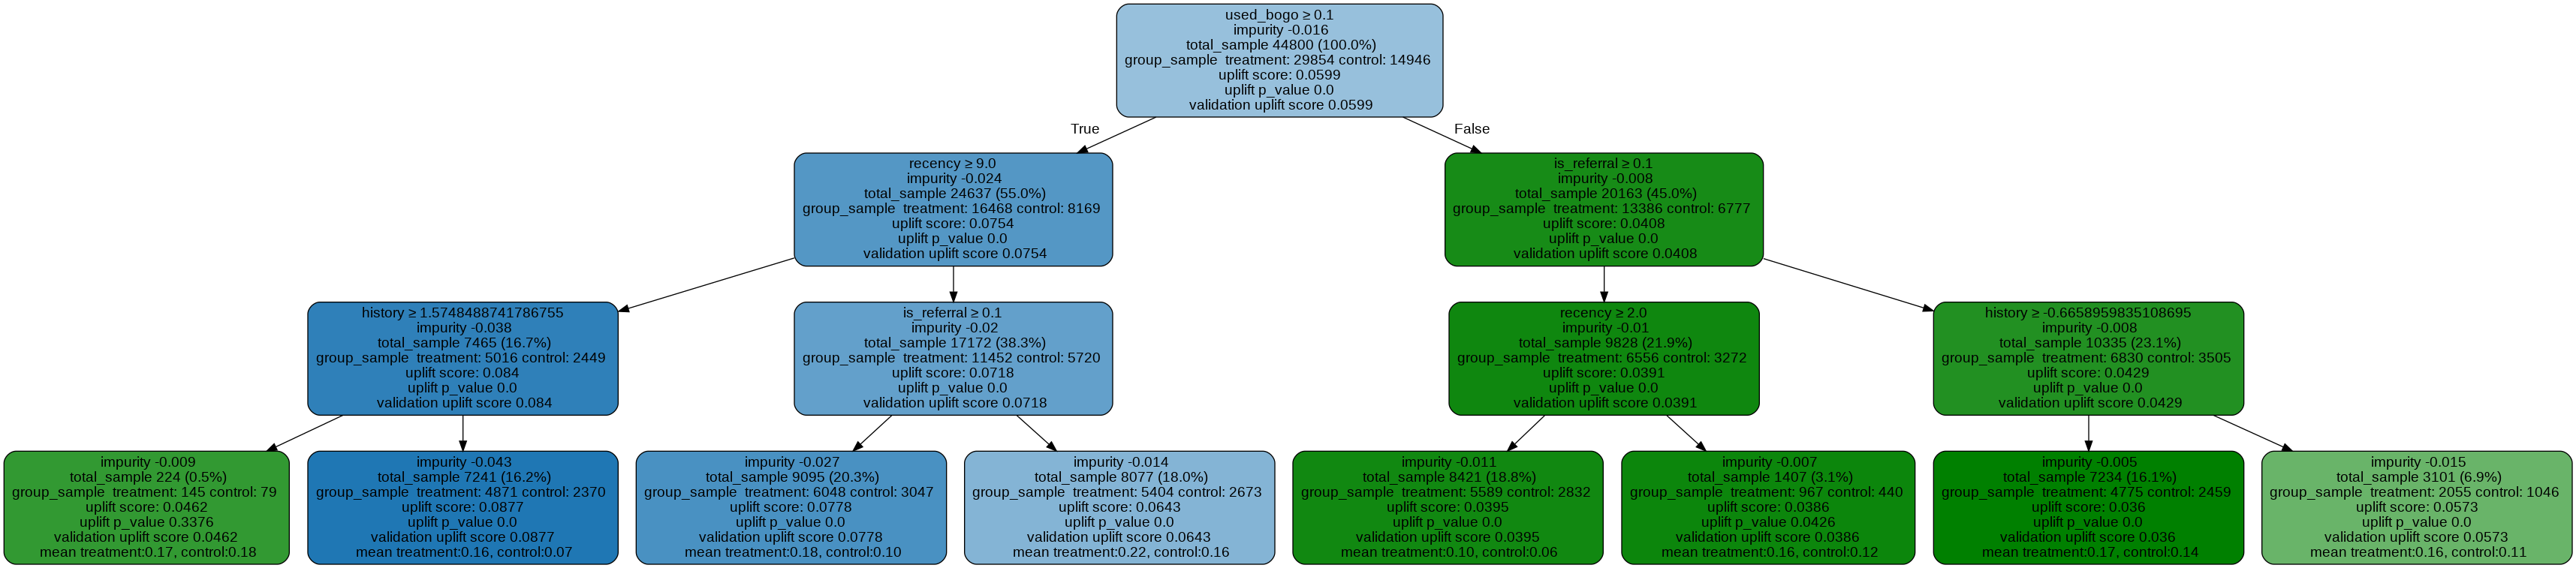

CPU times: user 1.67 s, sys: 16.8 ms, total: 1.68 s
Wall time: 2.19 s


In [34]:
%%time
from IPython.display import Image, display
from causalml.inference.tree import UpliftTreeClassifier, UpliftRandomForestClassifier
from causalml.inference.tree import uplift_tree_string, uplift_tree_plot

uplift_model = UpliftTreeClassifier(max_depth=4, min_samples_leaf=200, min_samples_treatment=50,
                                    n_reg=100, evaluationFunction='KL', control_name='control')

uplift_model.fit(X_train.values,
                 treatment=treat_train.map({1: 'treatment', 0: 'control'}).values,
                 y=y_train)

graph = uplift_tree_plot(uplift_model.fitted_uplift_tree, SELECTED_FEATURE_NAMES)
display(Image(graph.create_png()))